# Import the packages

In [ ]:
# Import all packages required
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

# For Data Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# For building the LSTM Model
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import warnings
warnings.filterwarnings('ignore')
# For evaluating the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load and clean the dataset

In [ ]:
# Import data
df = pd.read_csv('/content/drive/MyDrive/Kigali_PM2.5.csv', index_col="Date (LT)")
df.head(3)

,Site,Parameter,Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name
Date (LT),,,,,,,,,,,,,
2022-02-14 01:00 PM,Kigali,PM2.5 - Principal,2022,2,14,13,-999.0,-999,NaN,28.9,UG/M3,1 Hr,Valid
2022-02-14 02:00 PM,Kigali,PM2.5 - Principal,2022,2,14,14,29.7,88,Moderate,30.4,UG/M3,1 Hr,Valid
2022-02-14 03:00 PM,Kigali,PM2.5 - Principal,2022,2,14,15,29.3,87,Moderate,28.7,UG/M3,1 Hr,Valid


In [ ]:
df1=df.drop(['Site','Parameter','Year','Month','Day','Hour','AQI Category','Conc. Unit','Duration','QC Name','NowCast Conc.','AQI'],axis=1)
df1

,Raw Conc.
Date (LT),
2022-02-14 01:00 PM,28.9
2022-02-14 02:00 PM,30.4
2022-02-14 03:00 PM,28.7
2022-02-14 04:00 PM,31.4
2022-02-14 05:00 PM,33.2
...,...
2023-04-30 08:00 PM,19.1
2023-04-30 09:00 PM,26.6
2023-04-30 10:00 PM,30.0


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/data.csv', index_col="Date")
data

,Raw Conc.
Date,
2022-02-14 13:00:00,28.9
2022-02-14 14:00:00,30.4
2022-02-14 15:00:00,28.7
2022-02-14 16:00:00,31.4
2022-02-14 17:00:00,33.2
...,...
2023-04-30 20:00:00,19.1
2023-04-30 21:00:00,26.6
2023-04-30 22:00:00,30.0


In [ ]:
data.isnull().sum()

Raw Conc.    0
dtype: int64

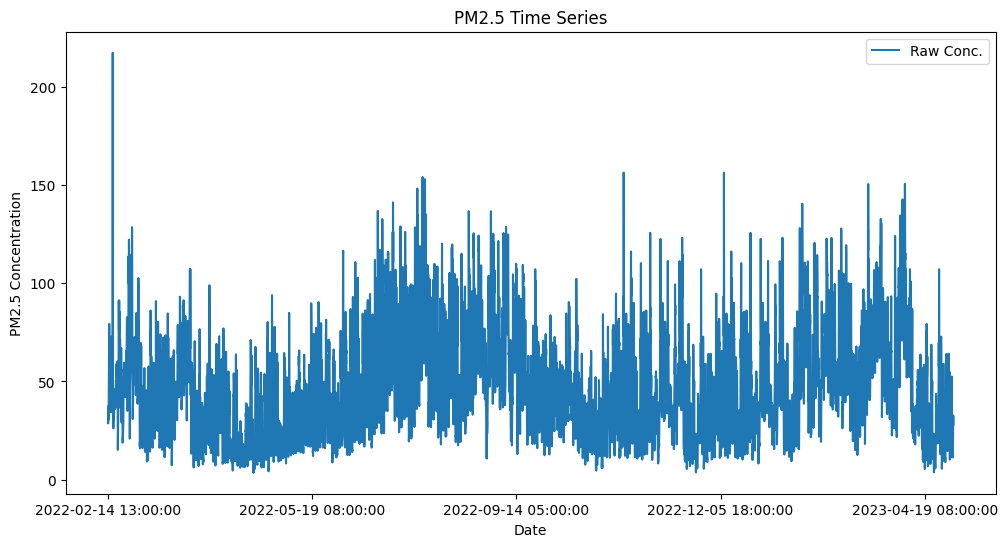

In [ ]:
data.plot(x='Date', y='Raw Conc.', figsize=(12,6))
plt.title('PM2.5 Time Series')
plt.ylabel('PM2.5 Concentration')
plt.show()

<Axes: ylabel='Density'>

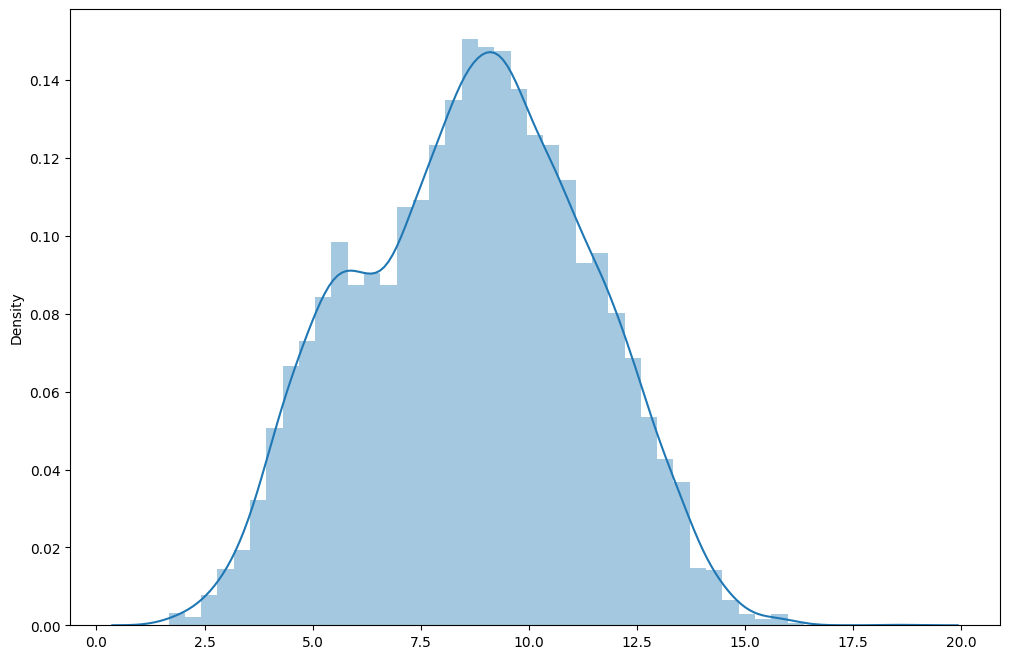

In [ ]:
plt.figure(figsize = (12,8))
transformed_data, _ = stats.boxcox(data['Raw Conc.'])
sns.distplot(transformed_data)

# Split the data

In [ ]:
#Load the dataset from the CSV file
dataset = pd.read_csv('/content/drive/MyDrive/data.csv')

# Extract the "Raw Conc." column as a numpy array
raw_conc = dataset['Raw Conc.'].values

# Define the sequence length (number of time steps)
sequence_length = 10

# Prepare empty lists for input sequences and corresponding target values
X = []  # Input sequences
y = []  # Target values

# Generate sequences
for i in range(len(raw_conc) - sequence_length):
    seq = raw_conc[i : i + sequence_length]  # Get a sequence of length 'sequence_length'
    target = raw_conc[i + sequence_length]  # Get the target value following the sequence
    X.append(seq)
    y.append(target)

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the data arrays
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (6616, 10)
y_train shape: (6616,)
X_test shape: (1655, 10)
y_test shape: (1655,)


In [ ]:
# Verify the sizes of the splits
print("Training set size:", len(X_train))
#print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Training set size: 6616
Testing set size: 1655


# Apply a model

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam 
import tensorflow as tf
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
import time
from sklearn.model_selection import GridSearchCV
import matplotlib.dates as mdates

In [ ]:
target_variable = data['Raw Conc.'].values

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create time series dataset
def create_dataset(dataset, n_steps):
    X, y = [], []
    for i in range(len(dataset) - n_steps):
        X.append(dataset[i:i+n_steps])
        y.append(dataset[i+n_steps])
    return np.array(X), np.array(y)

# Set the number of time steps for LSTM
n_steps = 1

# Create the time series dataset
X_train, y_train = create_dataset(train_data, n_steps)
X_test, y_test = create_dataset(test_data, n_steps)

In [ ]:
# Reshape the data to be 3D for LSTM input [samples, time steps, features]
n_features = 1
X_train = np.reshape(X_train, (X_train.shape[0], n_steps, n_features))
X_test = np.reshape(X_test, (X_test.shape[0], n_steps, n_features))

# Use Optimizer Adam

In [ ]:
#Define the LSTM model
timesteps = 1  
input_dim = 1
n_steps = 1
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(timesteps, input_dim)))
model.add(LSTM(units=16, input_shape=(n_steps, n_features)))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')
st=time.time()
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))
et=time.time()

Epoch 1/25
104/104 [==============================] - 15s 45ms/step - loss: 0.0314 - val_loss: 0.0189
Epoch 2/25
104/104 [==============================] - 2s 24ms/step - loss: 0.0111 - val_loss: 0.0077
Epoch 3/25
104/104 [==============================] - 2s 16ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 4/25
104/104 [==============================] - 1s 12ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 5/25
104/104 [==============================] - 1s 12ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 6/25
104/104 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/25
104/104 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/25
104/104 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 9/25
104/104 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 10/25
104/104 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss:

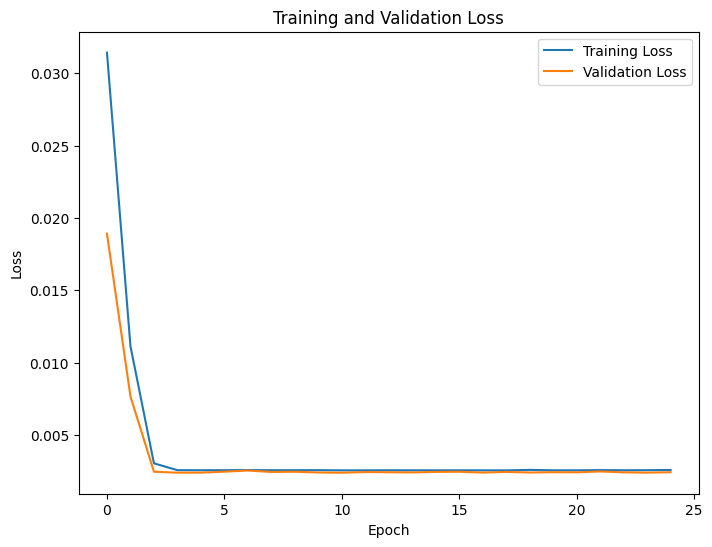

In [ ]:
# Plot the training loss and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

52/52 [==============================] - 0s 4ms/step


In [ ]:
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [ ]:
# Inverse transform the predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)

In [ ]:
# Calculate root mean squared error (RMSE) for training and testing predictions
train_rmse = np.sqrt(np.mean((trainPredict - y_train) ** 2))
test_rmse = np.sqrt(np.mean((testPredict - y_test) ** 2))

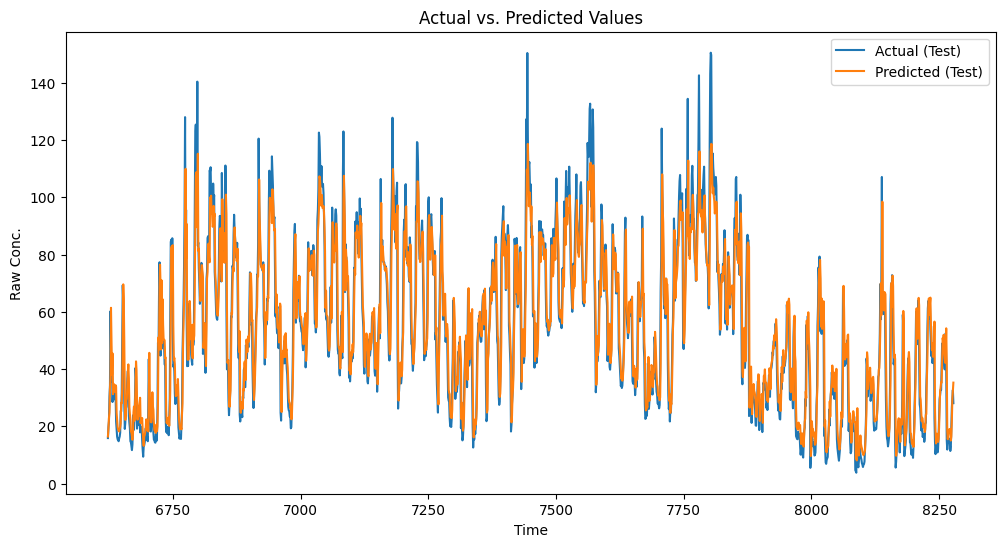

Train RMSE: 10.86
Test RMSE: 10.53
R-square: 0.8658961541697664
RMSE: 10.529698111320704
MAE: 7.408051405091217
Execution time: 50.09743690490723 seconds


In [ ]:
# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
#plt.plot(y_train, label='Actual (Train)')
#plt.plot(trainPredict, label='Predicted (Train)')
plt.plot(len(y_train) + np.arange(len(y_test)), y_test, label='Actual (Test)')
plt.plot(len(y_train) + np.arange(len(y_test)), testPredict, label='Predicted (Test)')
plt.xlabel('Time')
plt.ylabel('Raw Conc.')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# Print the root mean squared error
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Calculate R-square
r2 = r2_score(y_test, testPredict)
rmse = np.sqrt(mean_squared_error(y_test, testPredict))
mae = mean_absolute_error(y_test, testPredict)
elapsed_time=et-st
print("R-square:", r2)
print("RMSE:", rmse)
print("MAE:", mae)
print('Execution time:', elapsed_time, 'seconds')

In [ ]:
kk=data[6625:]
kk["testPredict"]=testPredict
kk["y_test"]=y_test
kk

,Raw Conc.,testPredict,y_test
Date,,,
2022-12-31 19:00:00,15.9,16.430359,15.9
2022-12-31 20:00:00,19.7,19.234993,19.7
2022-12-31 21:00:00,21.8,22.819914,21.8
2022-12-31 22:00:00,30.3,24.814440,30.3
2022-12-31 23:00:00,34.3,32.957817,34.3
...,...,...,...
2023-04-30 20:00:00,19.1,16.430359,19.1
2023-04-30 21:00:00,26.6,22.251699,26.6
2023-04-30 22:00:00,30.0,29.401876,30.0


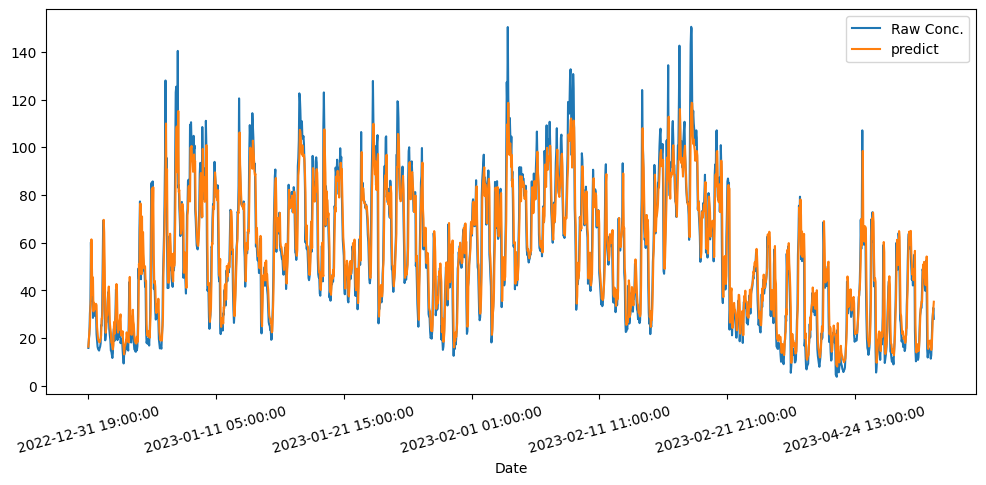

In [ ]:
plt.figure(figsize=(12,5))
kk["Raw Conc."].plot(label="Raw Conc.", rot=15)
kk["testPredict"].plot(label="predict", rot=15)
plt.legend()

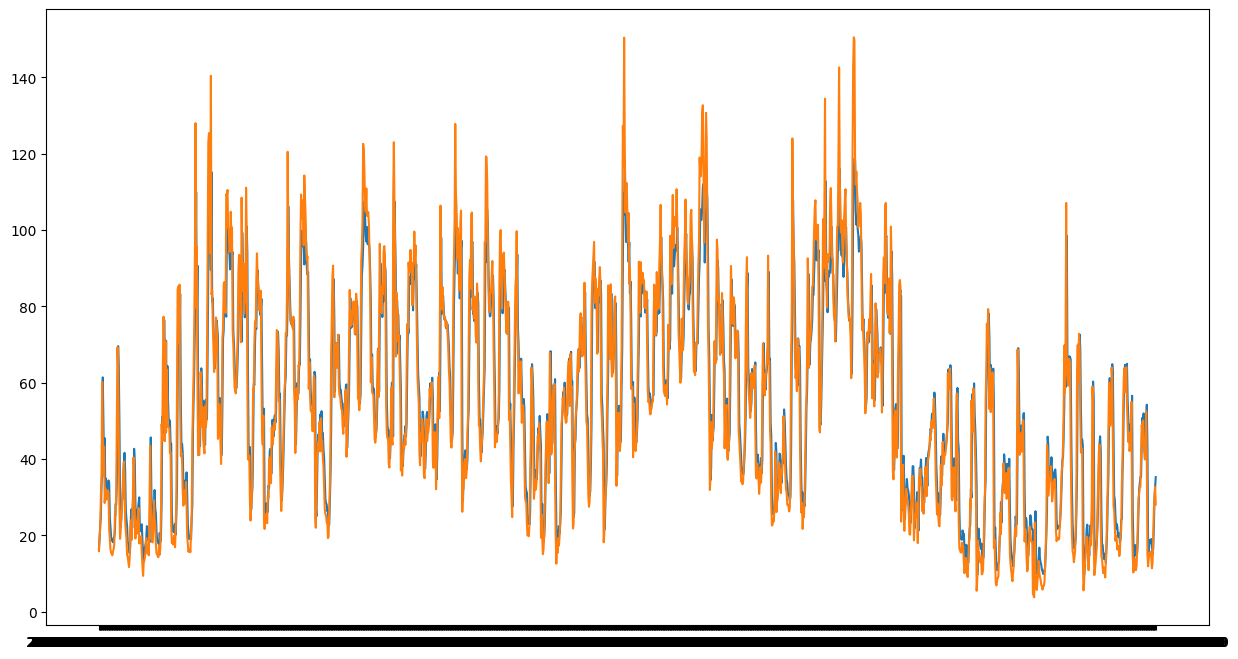

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(kk["testPredict"], label='Predicted (Test)')
plt.plot(kk["y_test"])

# Use Optimizer SGD

In [ ]:
target_variable = data['Raw Conc.'].values

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(target_variable.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create time series dataset
def create_dataset(dataset, n_steps):
    X, y = [], []
    for i in range(len(dataset) - n_steps):
        X.append(dataset[i:i+n_steps])
        y.append(dataset[i+n_steps])
    return np.array(X), np.array(y)

# Set the number of time steps for LSTM
n_steps = 1

# Create the time series dataset
X_train, y_train = create_dataset(train_data, n_steps)
X_test, y_test = create_dataset(test_data, n_steps)

In [ ]:
# Reshape the data to be 3D for LSTM input [samples, time steps, features]
n_features = 1
X_train = np.reshape(X_train, (X_train.shape[0], n_steps, n_features))
X_test = np.reshape(X_test, (X_test.shape[0], n_steps, n_features))

In [ ]:
from keras.optimizers import SGD
# Define the LSTM model
timesteps = 1  
input_dim = 1
n_steps = 1
model = Sequential()
#model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, input_dim)))
model.add(LSTM(units=1, input_shape=(n_steps, n_features)))
#model.add(Dense(4, activation='sigmoid'))
#model.add(Dense(units=1))
model.compile(optimizer=SGD(lr=0.1), loss='mse')
st=time.time()
history = model.fit(X_train, y_train, epochs=25, batch_size=12, validation_data=(X_test, y_test))
et=time.time()

Epoch 1/25
552/552 [==============================] - 4s 4ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 2/25
552/552 [==============================] - 2s 3ms/step - loss: 0.0083 - val_loss: 0.0100
Epoch 3/25
552/552 [==============================] - 2s 3ms/step - loss: 0.0065 - val_loss: 0.0076
Epoch 4/25
552/552 [==============================] - 2s 3ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 5/25
552/552 [==============================] - 2s 4ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 6/25
552/552 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 7/25
552/552 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 8/25
552/552 [==============================] - 2s 3ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 9/25
552/552 [==============================] - 2s 3ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/25
552/552 [==============================] - 2s 3ms/step - loss: 0.0026 - val_loss: 0.0027

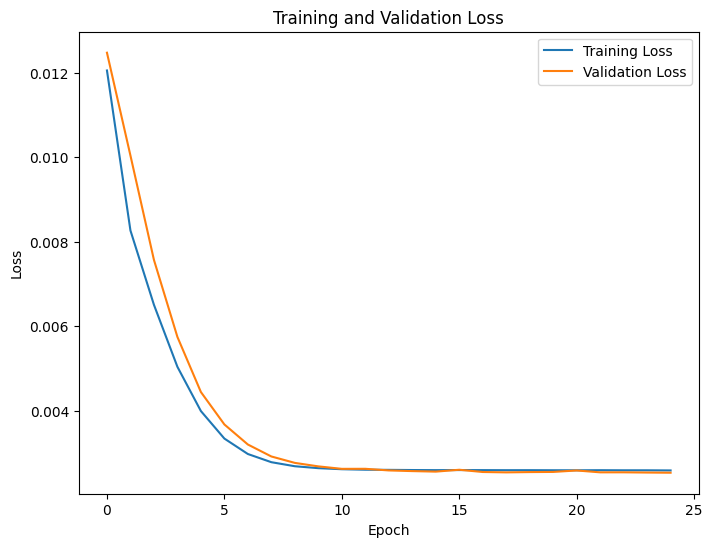

In [ ]:
# Plot the training loss and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

52/52 [==============================] - 0s 2ms/step


In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)

In [ ]:
train_rmse = np.sqrt(np.mean((trainPredict - y_train) ** 2))
test_rmse = np.sqrt(np.mean((testPredict - y_test) ** 2))

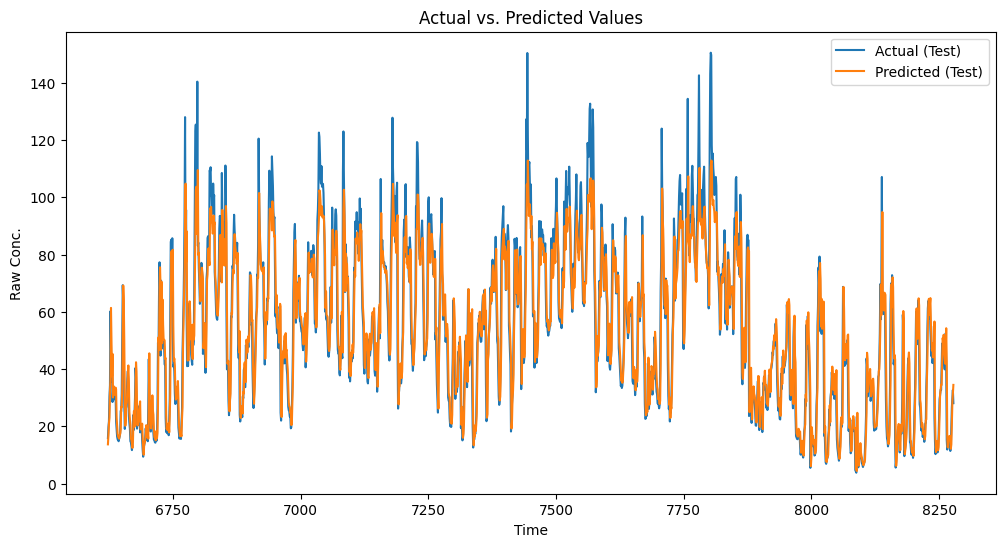

Train RMSE: 2305307.38
Test RMSE: 2665120.55
R-square: 0.860224040396753
RMSE: 10.750076255791585
MAE: 7.465326266991343
Execution time: 47.21854019165039 seconds


In [ ]:
# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
#plt.plot(y_train, label='Actual (Train)')
#plt.plot(trainPredict, label='Predicted (Train)')
plt.plot(len(y_train) + np.arange(len(y_test)), y_test, label='Actual (Test)')
plt.plot(len(y_train) + np.arange(len(y_test)), testPredict, label='Predicted (Test)')
plt.xlabel('Time')
plt.ylabel('Raw Conc.')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# Print the root mean squared error
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
r2 = r2_score(y_test, testPredict)
rmse = np.sqrt(mean_squared_error(y_test, testPredict))
mae = mean_absolute_error(y_test, testPredict)
print("R-square:", r2)
print("RMSE:", rmse)
print("MAE:", mae)
print('Execution time:', elapsed_time, 'seconds')